### Install the package

In [16]:
!pip install git+https://github.com/divamgupta/image-segmentation-keras

  Cloning https://github.com/divamgupta/image-segmentation-keras to c:\users\adesu\appdata\local\temp\pip-req-build-hbx0_na_


###### Download the dataset

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd drive/MyDrive/Colab\ Notebooks/

In [3]:
import os
from PIL import Image
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import random

# !pip install opencv-python
import cv2
import numpy as np
import glob
from tqdm import tqdm

In [4]:
workSpace = "..//"

<class 'numpy.ndarray'> (2048, 2048, 3) uint8
<class 'numpy.ndarray'> (2048, 2048) uint8 [0 1 2]


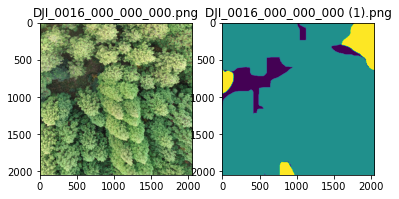

In [5]:
imagesDir = workSpace + "01_dataset_Seg//RingyouC_2Class//orgImage_Sugi1_Hinoki2_2048x2048_512_flip_rotated//"
anntasDir = imagesDir.replace("org","msk")

imagePaths_train = glob.glob(imagesDir + "*")
imagePaths_train.sort()

imgPath = random.choice(imagePaths_train)

img = Image.open(imgPath)
img_np = np.array(img)
print(type(img_np),img_np.shape, np.dtype(img_np[0,0,0]))
annotPaths_train = glob.glob(anntasDir +"*")
annotPaths_train.sort()

ann = Image.open(imgPath.replace("org","msk"))
ann_np = np.array(ann)
print(type(ann_np),ann_np.shape, np.dtype(ann_np[0,0]),np.unique(ann_np))

plt.subplot(1,2,1)
plt.title(os.path.basename(imagePaths_train[0]))
plt.imshow(img_np/255)
plt.subplot(1,2,2)
plt.title(os.path.basename(annotPaths_train[0]))
plt.imshow(ann_np)


In [6]:

class_count = 3

# for annPath in tqdm(random.sample(annotPaths_train,200)):
#     img = cv2.imread(annPath)

#     if class_count < len(np.unique(img)):
#         class_count = len(np.unique(img))
# class_count

In [7]:
print(len(glob.glob(imagesDir + "*")), imagesDir)
print(len(glob.glob(anntasDir + "*")), anntasDir)

from pprint import pprint

for imgPath in glob.glob(imagesDir + "*"):
    annPath = imgPath.replace("org","msk")
    assert os.path.basename(imgPath)==os.path.basename(annPath)
    # pprint(os.path.basename(imgPath))

854 ..//01_dataset_Seg//RingyouC_2Class//orgImage_Sugi1_Hinoki2_2048x2048_512_flip_rotated//
1345 ..//01_dataset_Seg//RingyouC_2Class//mskImage_Sugi1_Hinoki2_2048x2048_512_flip_rotated//


In [8]:
from pytz import timezone
from datetime import datetime

def nowTimeStr():
    utc_now = datetime.now(timezone('UTC'))
#   print(utc_now)
    jst_now = utc_now.astimezone(timezone('Asia/Tokyo')).strftime("%Y%m%d_%H%M")
#   print(jst_now.strftime("%Y%m%d%H%M%S"))
#   id_str = str(id).zfill(3)
    return jst_now

nowstr = nowTimeStr()
nowstr

'20201228_0323'

In [ ]:
import sepDataset

trainDir , validDir, testDir = sepDataset()

### Initialize the model

In [9]:
from keras_segmentation.models.unet import unet_mini

model = unet_mini(n_classes=class_count , input_height=1024,  input_width=1024 )


Using TensorFlow backend.


In [ ]:


trainingOutputDir = workSpace + "02_SegmentationTrain_output//Training_1024to1024Train_" + nowstr + "//"
os.makedirs(trainingOutputDir, exist_ok=True)
print(trainingOutputDir)

model.train(
    train_images =  imagesDir,
    train_annotations = anntasDir,
    checkpoints_path = trainingOutputDir,
    epochs=50, do_augment=True)

..//02_SegmentationTrain_output//Training_1024to1024Train_20201228_0323//


### Train the model

In [ ]:
# evaluating the model 
print(model.evaluate_segmentation( inp_images_dir=imagesDir  ,
                                  annotations_dir=anntasDir ) )

In [ ]:
out = model.predict_segmentation(
    inp=imagePaths_train[0],
    out_fname="/out.png"
)

In [ ]:
msk = cv2.imread(annotPaths_train[0])
print(np.unique(msk))
msk = msk/np.max(msk)
print(np.unique(msk))
plt.imshow(msk)

In [1]:
plt.subplot(1,3,1)
plt.imshow(np.array(Image.open(imagePaths_train[0])))
plt.subplot(1,3,2)
plt.imshow(msk)
plt.subplot(1,3,3)
plt.imshow(out)


NameError: name 'plt' is not defined

In [ ]:
def resizeSize(pilImg, SlideSize):
    width, height = pilImg.size
    resizeForSlideSize = (width // SlideSize * SlideSize, height // SlideSize * SlideSize)
    return resizeForSlideSize #(w,h)



def predictUAVimg(predictImgPath, SlideSize, predictImgSize):
    ImgName = os.path.basename(predictImgPath)

    imgWidth = predictImgSize

    print(ImgName, "を予測しています。")
    org_img = Image.open(predictImgPath)
    width , height = org_img.size
    print(width , height)

    resizeForSlideSize = resizeSize(org_img,SlideSize)

    # 予測結果を貼り付ける先のキャンバス作成
    imgCanvas_prd = Image.new('L',resizeForSlideSize)


    #画像サイズとクリップサイズで切りがいい画素サイズにリサイズする。
    org_img_resize = org_img.resize(resizeForSlideSize)

    #分割画像サイズ　と　スライドサイズに応じて、元画像の縦横幅から、縦横の分割数を計算して取得
    xl = (width - (imgWidth - SlideSize))// SlideSize
    yl = (height - (imgWidth - SlideSize))// SlideSize
#     print("水平方向 xl: " + str(xl) + "  垂直方向 yl " + str(yl))

    prdSize = (predictImgSize, predictImgSize)

  
    #元画像1枚に対する処理
    for x in range(xl):
        for y in range(yl):

            box = (x*SlideSize,y*SlideSize,x*SlideSize+imgWidth,y*SlideSize+imgWidth)

            org_img_resize_crop = org_img_resize.crop(box)
            org_img_resize_crop_resize = org_img_resize_crop.resize(prdSize)

            org_img_resize_crop_resize.save("./temp_pred.png")

            # 元画像を変換して、モデルで予測を実行する。
            raw_orgResizeNp = model.predict_segmentation(inp="./temp_pred.png")
            
            #　numpy→PILへ変換してキャンバスに貼り付け          
            prd_crop_img = Image.fromarray(np.uint8(raw_orgResizeNp))
            
            prd_crop_img = prd_crop_img.resize(org_img_resize_crop.size)
            
            imgCanvas_prd.paste(prd_crop_img, (x * SlideSize, y * SlideSize))

    #予測結果を元画像サイズに戻す
#     imgCanvas_org = imgCanvas_org.resize((width , height))
    imgCanvas_prd = imgCanvas_prd.resize((width , height))  

    return imgCanvas_prd



In [37]:
# !ls 03_Predicted_Image_04_20200812_0336Model_unet

In [ ]:
predPaths = glob.glob(workSpace + "01_dataset_Seg/RingyouC_Forest_Drone_SugiHinoki_2Class/orgImage/*.jpg")

for predPath in tqdm(predPaths):
    # predPath = ".//03_Predicted_Image_04_20200812_0336Model_unet//DJI_0014_org.jpg"
    pred = predictUAVimg(predPath, 512, 1024)

    predDir = os.path.dirname(os.path.dirname(predPath)) + "prdImage_arg//"
    os.makedirs(predDir,exist_ok=True)
    pred.save(predDir + os.path.basename(predPath))

In [ ]:
plt.imshow(np.array(pred))

In [38]:
# o = model.predict_segmentation(
#     inp="dataset1/images_prepped_test/0016E5_07965.png",
#     out_fname="/tmp/out.png" , overlay_img=True, show_legends=True,
#     class_names = [ "Sky",    "Building", "Pole","Road","Pavement","Tree","SignSymbol", "Fence", "Car","Pedestrian", "Bicyclist"]

# )

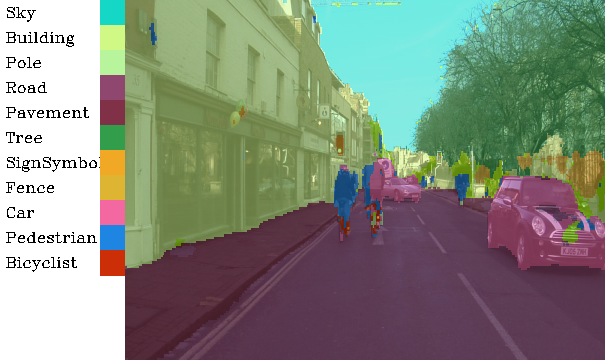